# Case Study: Contrail Segmentation 
## On the Importance of Understanding Your Data and Task
*Rolls off the tongue, doesn't it?* - The Authors of This Notebook

This notebook presents a set of exercises in the form of a case study on segmenting contrails from satellite image (also referred to as remote sensing data). 

*Prerequisties*:
- Basic machine learning knowledge 
- Basic familiarity with the paper "Few-Shot Contrail Segmentation in Remote Sensing Imagery With Loss Function in Hough Space" by Junzi et al. (https://ieeexplore.ieee.org/document/10820969). We do not expect you to understand the whole paper, but rather to have an idea of what is being done.

*The goal by the end of this notebook is for students to:*
- Gain an exposure to a new application of artificial intelligence - extracing semantics from satellite images 
- Understand when they can consider the specifics of their data and task
- Gain exposure to methods to take advantage of their task
- Understand how to evaluate machine learning tasks based on the goal they are solving 
- Go beyond the technical understanding of the problem and consider where this application will be used, will it even be helpful, etc.

## Introduction: Contail Segmentation
The paper "Few-Shot Contrail Segmentation in Remote Sensing Imagery With Loss Function in Hough Space" by Junzi et al. focuses on creating an automatic segmentation procedure for contrails when using few data samples by taking advantage of what we know about the problem. In this section, the problem is introduced from the very basics of what a contrails is, to a mathematical formulation of the issue. 

<p align="center">
  <img src="images/what-is-a-contrail.png" width="800"/>
</p>

*What is a contrail?* 

Contrails or vapour trails are line-shaped clouds produced by aircraft engine exhaust or changes in air pressure, typically at aircraft cruising altitudes several kilometres/miles above the Earth's surface. (Definition - https://en.wikipedia.org/wiki/Contrail)

*Why does it matter?* 

The Sun emits solar radiation towards the Earth that the ground traditionally reflects back. However, the formation of the ice crystals in contrails creates a dense enough "shield" to reflect a part of them back. This impacts the amount of radiation trapped around the Earth and thus contributes to the temperature. They also have a potential cooling effect on sun rays getting reflected back towards the Sun, though this effect is currently estimated to be smaller.


**Satellite Image** 

Satellite images are a unique form of data. As the name implies, they are taken by a satellite, which leads to charactersitics about it, such as:
- **top-down**: the perspective of the image is always orthogonal towards the ground 
- **distance from the Earth**: Depending on the image, and satellite both the distance to the Earth and the resolution of the image is different. 
    - For this reason, the resolution is measured in terms of actual distance (e.g. A resolution of 30cm means that 30cm of information is encoded per pixel.)
    - Common resolutions are 30cm, 1m, 2m. Correspondingly a smaller distance corresponds to higher quality, more expense, harder to get, etc.
- **multispectral data**: Sensory information from satellites is more advanced than traditional cameras. They can capture more than just the color spectrum. Each one is a special band (channel in images). Below are listed some examples: 
    - RGB (Red-Green-Blue): The channels traditional cameras capture, and are blended together to create a final image
    - Infrared/Near-Infrared: A channel where some surfaces react differently to - for example, vegetation reacts differently to infrared light. Can reveal new information, not visible to the naked eye.
    - Point Clouds (LiDAR): A channel capturing distance to the earth. Used to map out things like elevation via the laser reflecting back. 
    - And many others, depending on the sensor used ... We will introduce them in this notebook if and as necessary.

<div style="display: flex; justify-content: space-around;">
   <img src="images/remote-sensing-platforms.webp" width="450"/>

</div>

[Image Source: GeeksForGeeks](https://imgs.search.brave.com/ebFlnbhNCKYFr760b0JRrC-BQlpJUeTmlB5SUw-5Nf4/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5nZWVrc2ZvcmdZWtzLm9yZy93cC)




Below are listed some example images of contrail images taken from different satellites and bands: 


<div style="display: flex; justify-content: space-around;">
  <img src="images/1-MeteoSat 11.png" width="350"/>
  <img src="images/2-NASA Terra.jpg" width="350"/>
  <img src="images/3-NOAA Suomi-NPP.jpg" width="350"/>
</div>

[Image Source TBD](TBD)


## Project Setup

### Create an Anaconda Environment and Download Requirements
If you haven't already setup the codebase following the instructions of the README, you can do so here. Otherwise, you can skip running this.

In [ ]:
%conda create -y -n contrail-project python=3.12
%conda activate contrail-project
%conda install -y pip
%pip install -r requirements.txt

### Get Imports

In [1]:
import os
import random
import numpy as np
import torch
from getpass import getpass
import os
from sklearn.model_selection import train_test_split
from data_util.AudioMNIST.load_data import load_audio_data, load_audio_data_noisy
from visualization.show_audio import visualize_waveform_and_play_audio
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from data_util.AudioMNIST.split_data import get_balanced_indices_by_targets
from visualization.show_metrics import plot_accuracy_vs_subset_size
from visualization.feature_importance import plot_aug_comparison
from torch import nn, optim
from tqdm import tqdm
from data_util.MNIST.raw.mnist_loading import load_mnist_data
from models.simpleCNN import SimpleCNN
import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display
import io
from visualization.show_images import visualize_pytorch_dataset_images
import albumentations as A
from visualization.interactive_menu import retrieve_mnist_menu, AlbumentationsTransform
import sys
sys.path.append("contrail-seg")
from train import train_contrail_network

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Force deterministic behavior in cudnn (might slow things down)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## What is Contrail Segmentation?

What are we trying to accomplish? From the name **contrail segmentation**, and the information beforehand, we know that we are trying to extract information out of the satellite images. To do so, we need to define **segmentation** first.

#### Segmentation

Recall **classification**, abstracted from any machine learning model. Given an input $x$, we want to get an output $\widehat y$ corresponding to the correct class $y$ of the object $x$. 

In remote sensing, our inputs are images. Therefore $x \in \mathbb R^{W \times H \times C} $ where $W, H$ are the height and width (in pixels) of the current image and $C$ the number of channels total the image (recall RGB or Infrared introduced previously). Mathematically, this is a **tensor** (it is not very important for today, but good to know in general). 

In **segmentation**, we want to semantically understand our image. A way to do this is to somehow classify what we are seeing in our image. One way to do this is to output another image, classifying each pixel, whether it belongs to the object/s we are looking for. This can be defined as creating a function $f:x \in \mathbb R^{W \times H \times C} \to y \in \mathbb Z_n$ where $n$ is the number of classes we have in our image. An illustration is provided below. Specifically, this is a case called **semantic segmentation**.


<div style="display: flex; justify-content: space-around;">
   <img src="images/semantic_segmentation.jpg" width="750"/>
</div>

[Image Source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.hitechbpo.com%2Fblog%2Fsemantic-segmentation-guide.php&psig=AOvVaw2xoq84cC-FovXhPj2KUpDB&ust=1752526997439000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCNDgz_7duo4DFQAAAAAdAAAAABAE)


The case of **contrail segmentation** can then be examined as just a subset of **semantic segmentation** where our classes are $n=2$ - "contrail" and "background". Illustration of $x$ and $y$ below:

<div style="display: flex; justify-content: space-around;">
   <img src="contrail-seg/data/goes/florida/image/florida_2020_03_05_0101.png" width="600"/>
   <img src="contrail-seg/data/goes/florida/mask/florida_2020_03_05_0101.png" width="600"/>
</div>

[Image Source TBD](TBD)

This is a challenging task. Throughout the study, the authors present ways they try to compensate for their lack of data (only around 30 images). **This is a common occurence in the ML industry**. In the following sections, you will go through exercises examining each of their approaches, try to add to them and apply them to a different case, and reason about if this is a correct application.

## Data Scarcity - Data Augmentation

Scarcity is an issue everybody who works with data faces eventually, even in foundational work - https://www.eecis.udel.edu/~shatkay/Course/papers/NetworksAndCNNClasifiersIntroVapnik95.pdf. **Data Augmentation** is a way to reduce overfitting on incomplete datasets. 

Intuitively, it introduces distortions to the small data samples, which vary during training so that the machine learning model of choice does not focus on arbitrary aspects of the data (such as the position of the object, such as a specific position or number). 

Mathematically, it changes the sampling from the training data set $X_{train}$ by a  affine transformation function $g: \mathbb R^n \to \mathbb R^n $, which is applied on every sample point $x \in X$ and outputs a different transformation each time. This change effetively increases the diversity in the training set distribution and brings the final estimate closer to the maximum likelihood on the complete data set $X$ where $X_{train} \subseteq X$. 

*Example* 

 Imagine a scenario where we have a small training set on flowers (such as the Iris dataset), where all daisies and poppies in the training set have a sepal width $s$ of $5$ and $7$ centimeters,  respectively. The test set, and correspondingly all real examples may have no such examples and there are daisies and poppies of many more sizes. A data augmentations technique may be making $g$ apply noise to the inputs, putting the daisies and poppies's $s$ within some standard deviation giving a random variable over the dataset $$s_{\text{augmented}} = s + \varepsilon, \quad \varepsilon \sim \mathcal N(0, \sigma^2)$$

 For instance, daisies might be sampled with sepal widths $5 \pm 0.5$. 


## Colab Setup

In [ ]:
from getpass import getpass
import os

# Securely input your token
token = getpass('Paste your GitLab token: ')

# Set the repository URL
repo_url = "https://oauth2:" + token + "@gitlab.ewi.tudelft.nl/tjviering/contrails.git"

# Clone the repository
!git clone --branch data-augmentation --single-branch {repo_url}
# 9WrCsxUVdPYmy7uij2Fn - Token
# Verify clone
!ls contrails  # Should show repository contents
os.chdir("contrails")
%pip install -r requirements.txt

**This section introduces data augmentation in two modalities: audio and images. Later, we will also show the value of that on our task of contrails.**

One is a fully-guided example, the other ones need to have either code filled in and/or theoretical questions answered. Finally, this is all related to the contrail case. 

### Audio

Here we show a simple task: audio classification. Given an audio file, can we understand automatically what number is being said based on the recording? For this purpose, we are going to use a subset of the AudioMNIST dataset, and evaluate performance on it both with and without data augmentation. 

https://github.com/soerenab/AudioMNIST - AudioMNIST


In [35]:
max_samples = 100
X_audio, y_audio, wavs = load_audio_data('data_util/AudioMNIST/free-spoken-digit-dataset-master/recordings', max_samples=max_samples)
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(X_audio, y_audio, test_size=0.2, random_state=42)

100%|██████████| 100/100 [00:01<00:00, 64.51it/s]


#### Original Audio Samples

An audio file is created when an analog processor converts sound waves into a sequence of amplitudes and spectrograms. They respectively give an idea of when the volume and frequency are higher. When it is played, it is also just an array of amplitudes, showing the intensity. By looking at the waveform graphs, you can clearly discern when someone is speaking, and also play the audio.

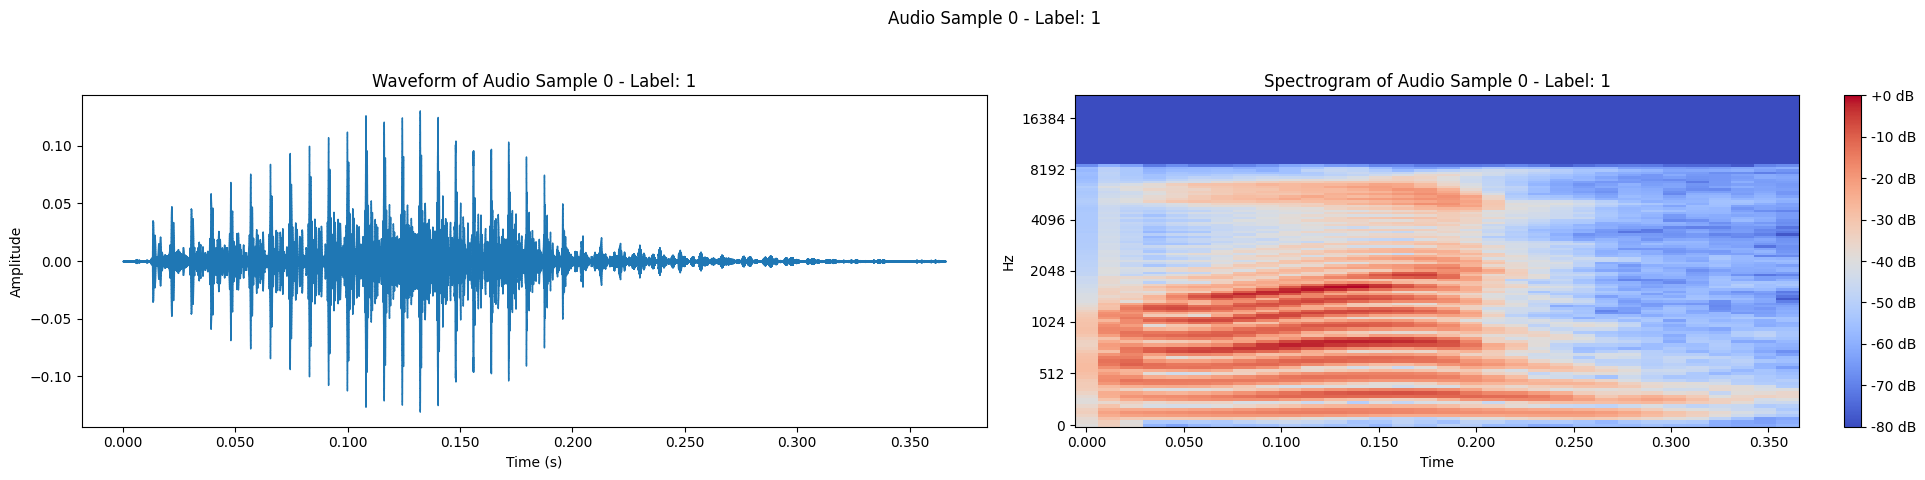

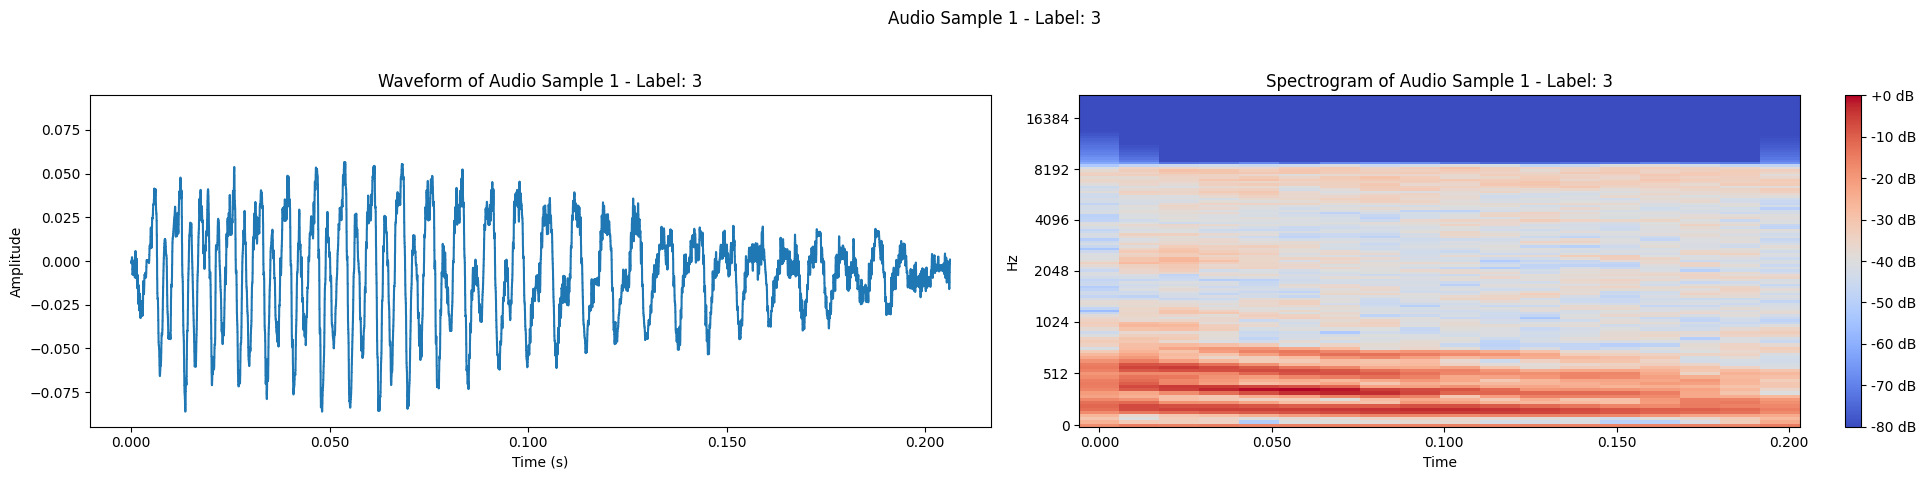

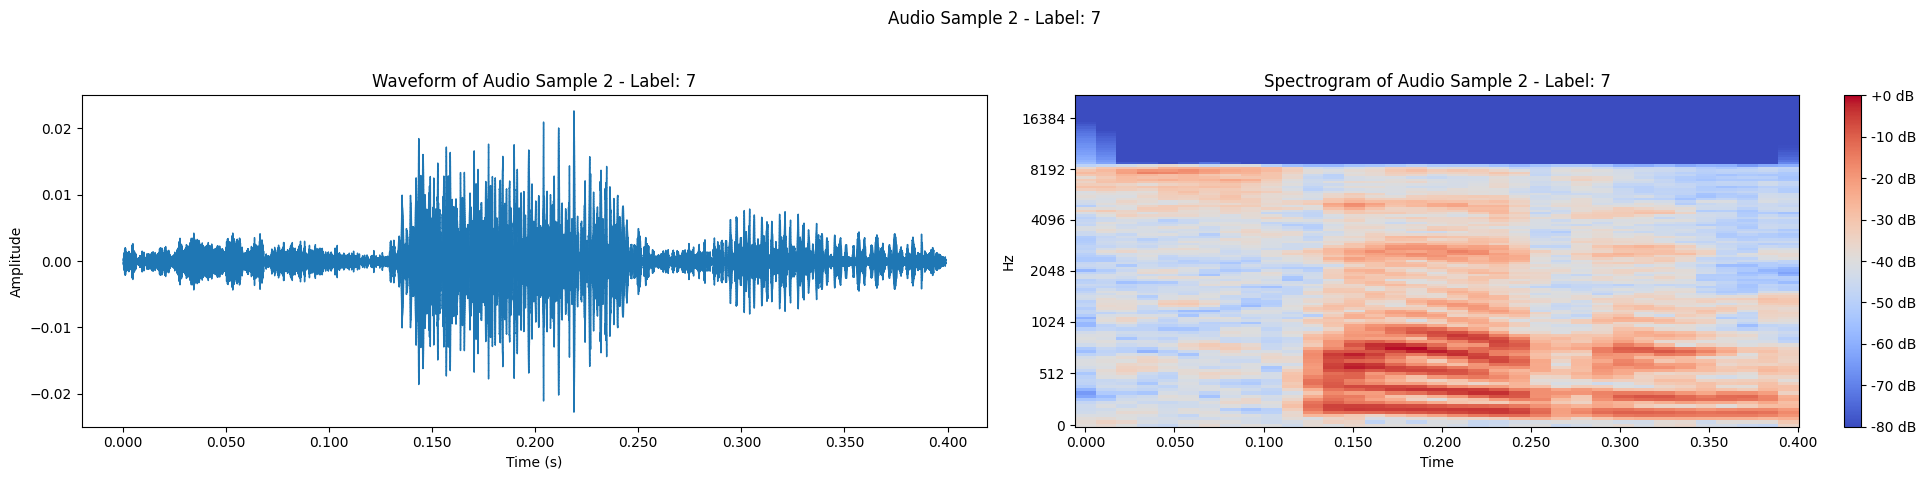

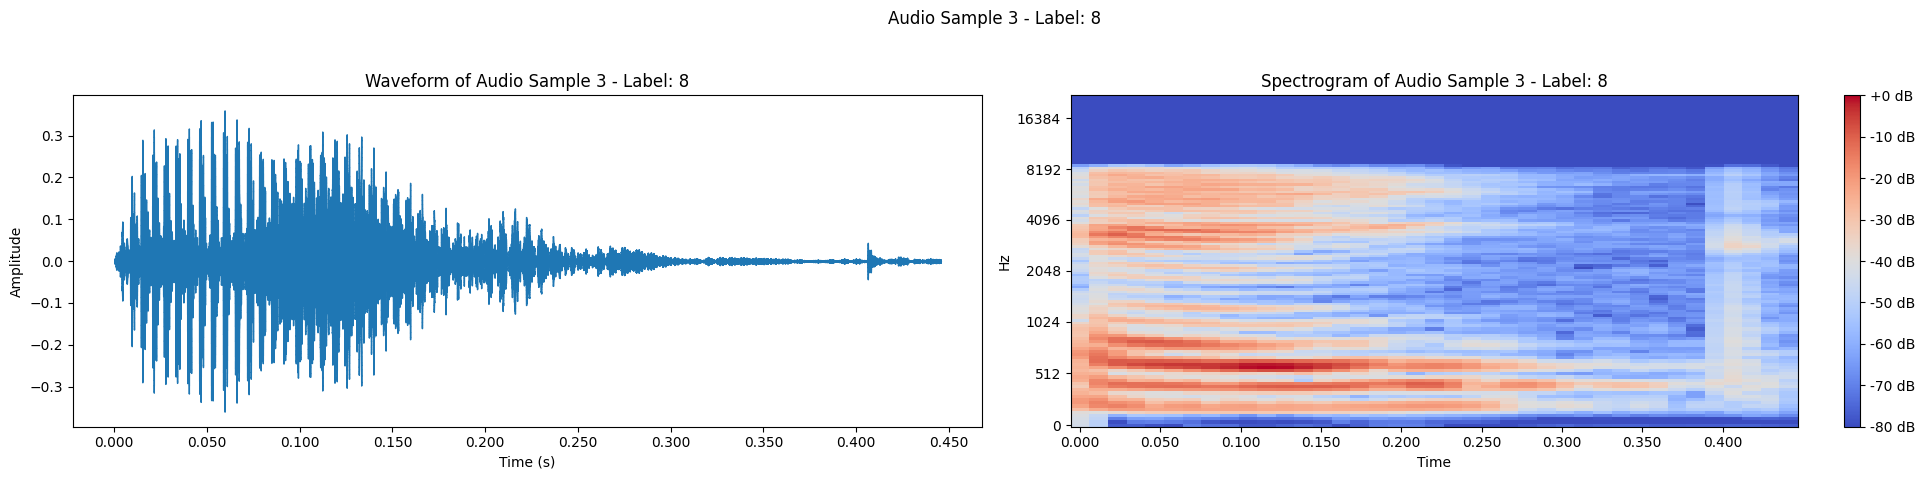

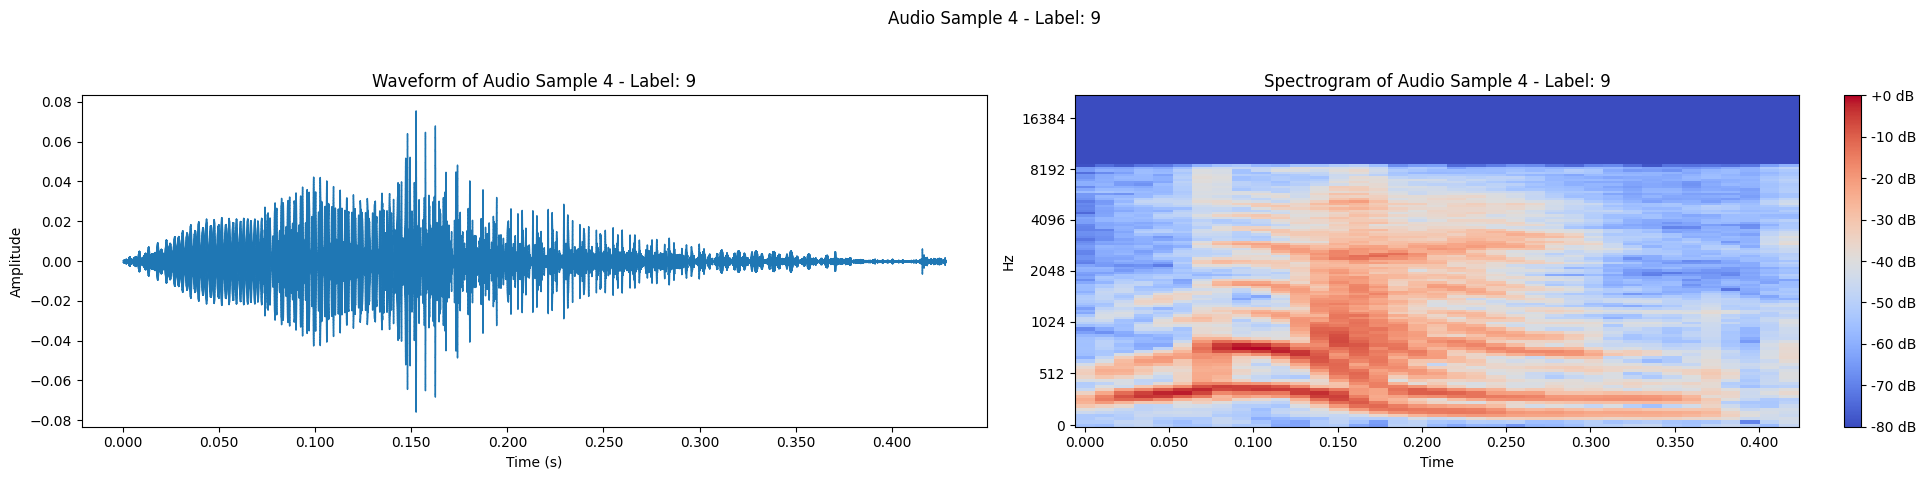

In [36]:
visualize_waveform_and_play_audio(y_audio[:5], wavs[:5])

#### Augmented Audio Samples

This signal seems to have lots of amplitudes, right, and varying length, based on the person, voice, etc. We have prepared an MNIST dataset, of numbers. However, if we change certain things about the signal, would it necessarily change the label. For example:
- speeding up or slowing down the speech still gives the same number 
- shifting the pitch as well
- adding noise, making a worse recording should not change the outcome as well

This is all a form of **data augmentation** - changes to our data that does not impact how our model should treat it, while being more adversarial and challenging for it. Below we have prepared one of the examples previously listed - adding Gaussian noise. 

Below are two cells, the first one is a barebones augmentation function adding Gaussian noise to the signal, essentially perturbing it. 


Take a listen and see if the numbers are still discernable. Also, try to examine how the signal looks visually different. Is there anything different about the wav file and the spectrograms. 

In [37]:
def augmentation_function(x, sigma=0.01):
    import numpy as np
    return x + np.random.normal(0, sigma, len(x))  
X_audio_augmented, y_audio_augmented, wavs_augmented = load_audio_data_noisy('data_util/AudioMNIST/free-spoken-digit-dataset-master/recordings', augmentation_function, max_samples=max_samples)
X_audio_train_augmented, _, y_audio_train_augmented, _ = train_test_split(X_audio_augmented, y_audio_augmented, test_size=0.2, random_state=42)

100%|██████████| 100/100 [00:03<00:00, 26.35it/s]


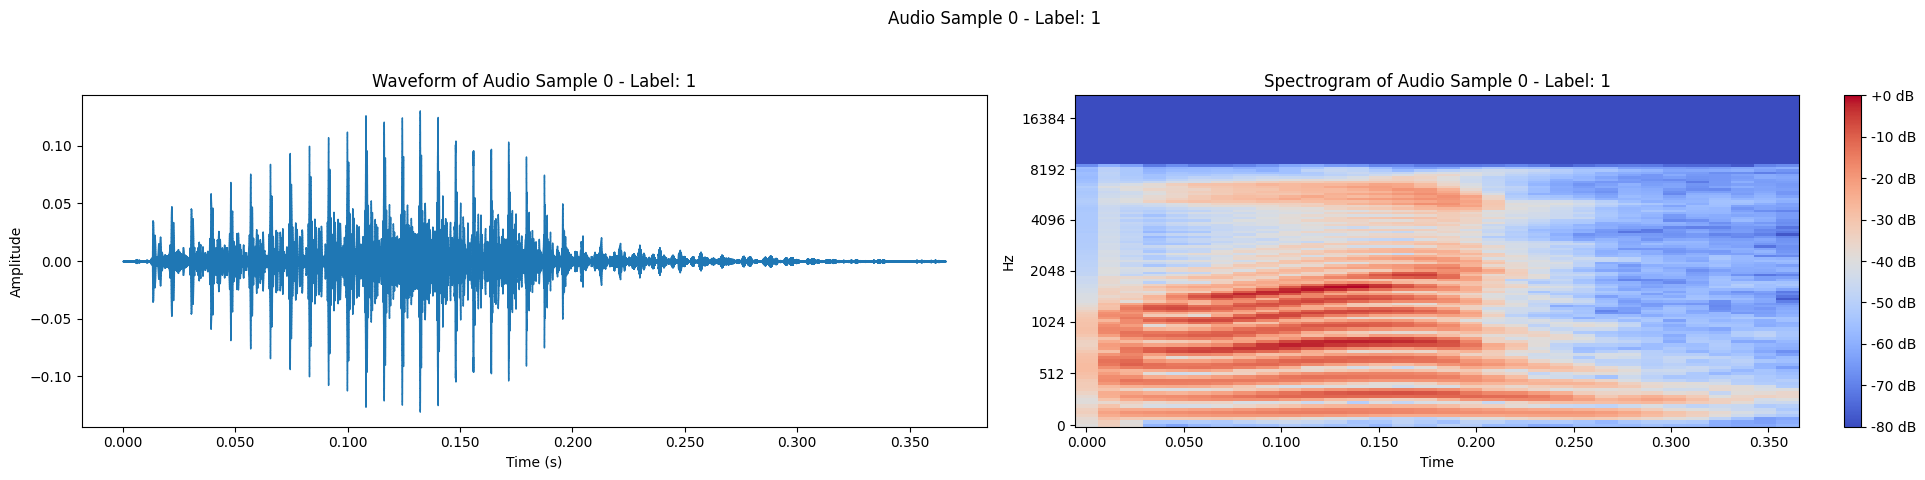

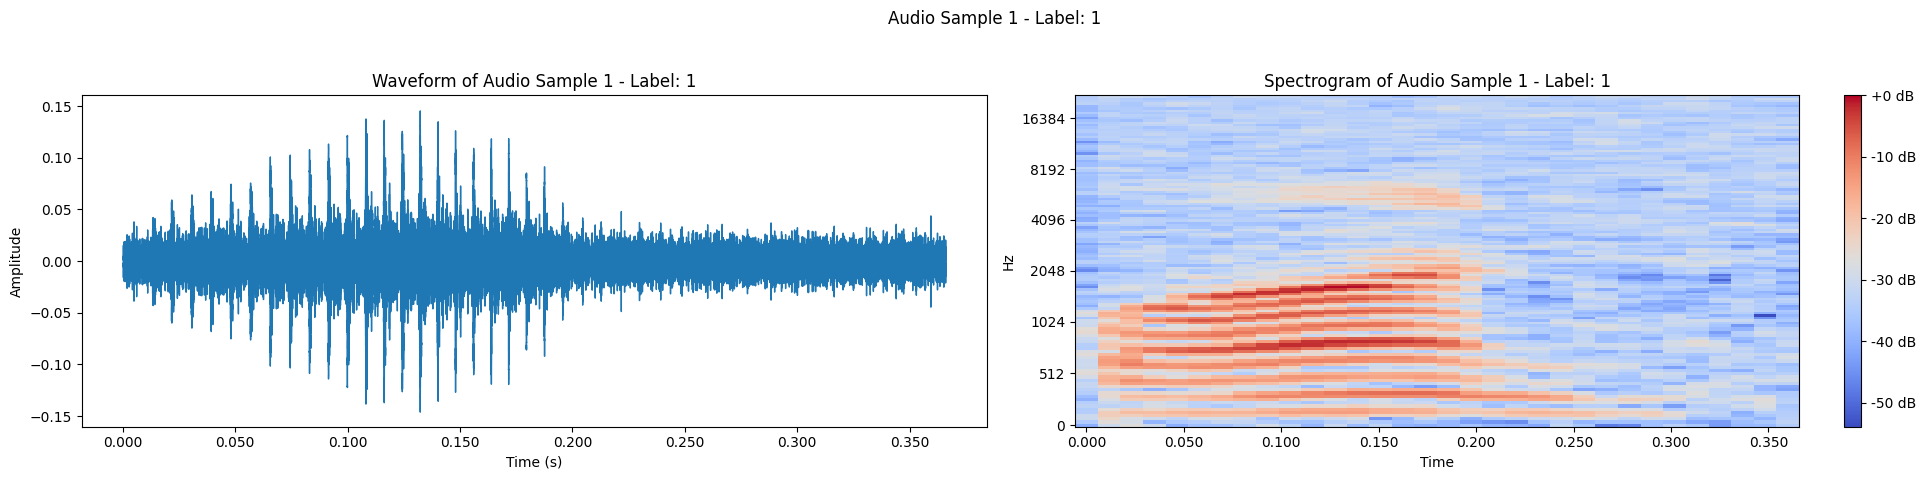

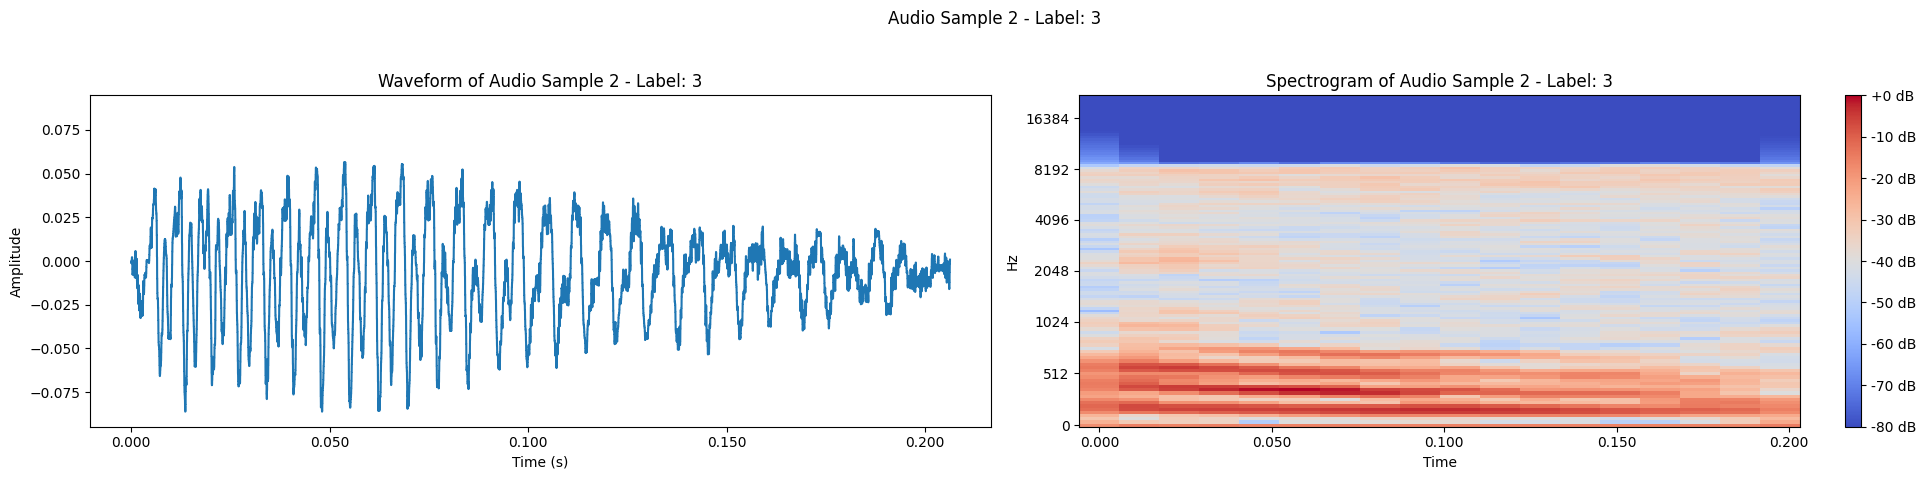

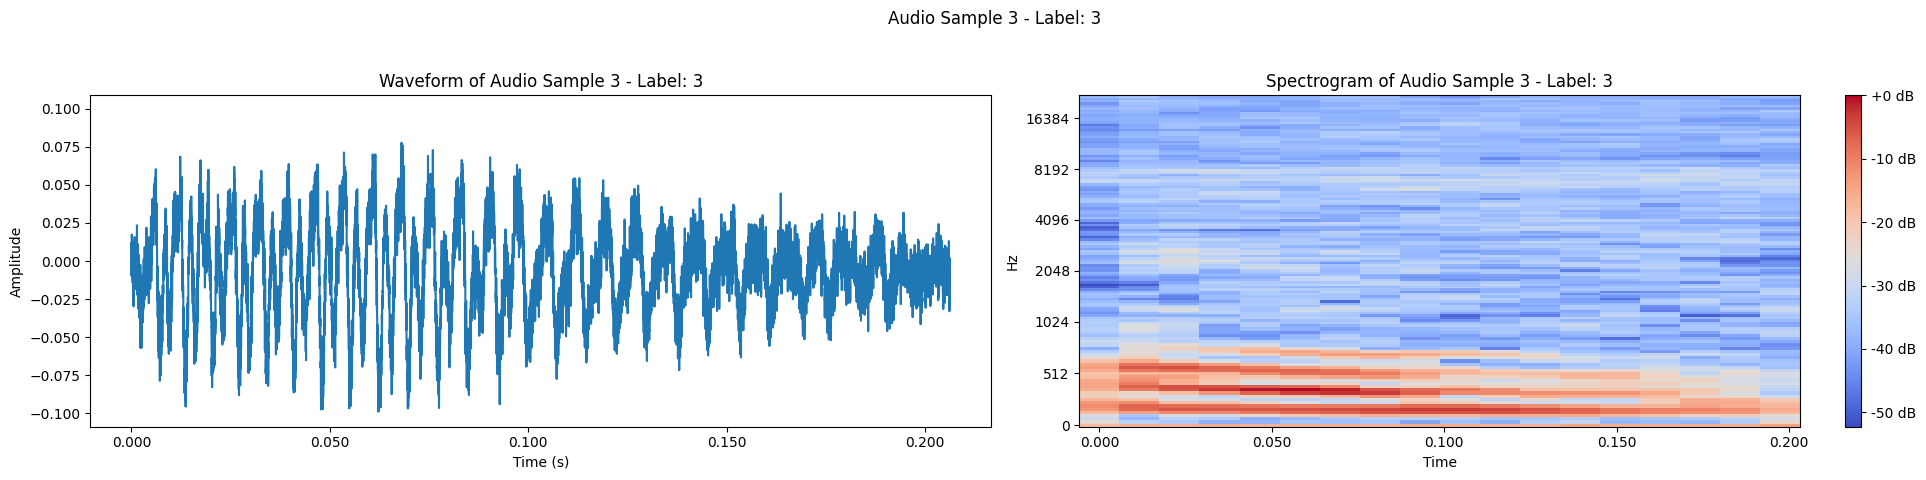

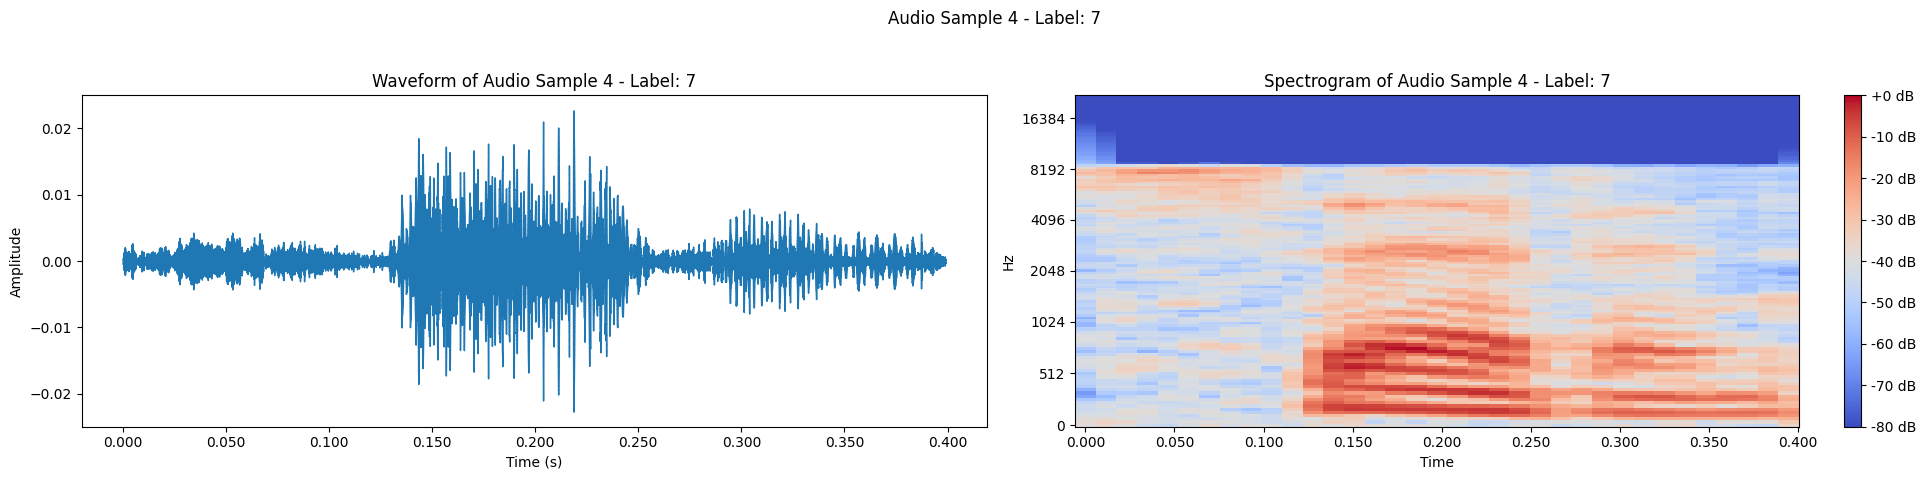

In [38]:
visualize_waveform_and_play_audio(y_audio_augmented[:5], wavs_augmented[:5])

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
How is the amplitude (the left plot) different for the augmented samples – why?  
What would happen if we increase $\sigma$, which is currently $\sigma = 0.01$?

---

**Answer:**  
Due to the Gaussian noise, the amplitude randomly fluctuates up and down, and it sounds like a distortion. It is visible in the signal being more wavy.

</div>


#### Additional Augmentations

Adding noise is not in this case the only transformation we can do to keep the label/nature of the audio the same. Below are some other examples. After them there are some questions about the transformations - explain why they work.

100%|██████████| 100/100 [00:03<00:00, 29.95it/s]


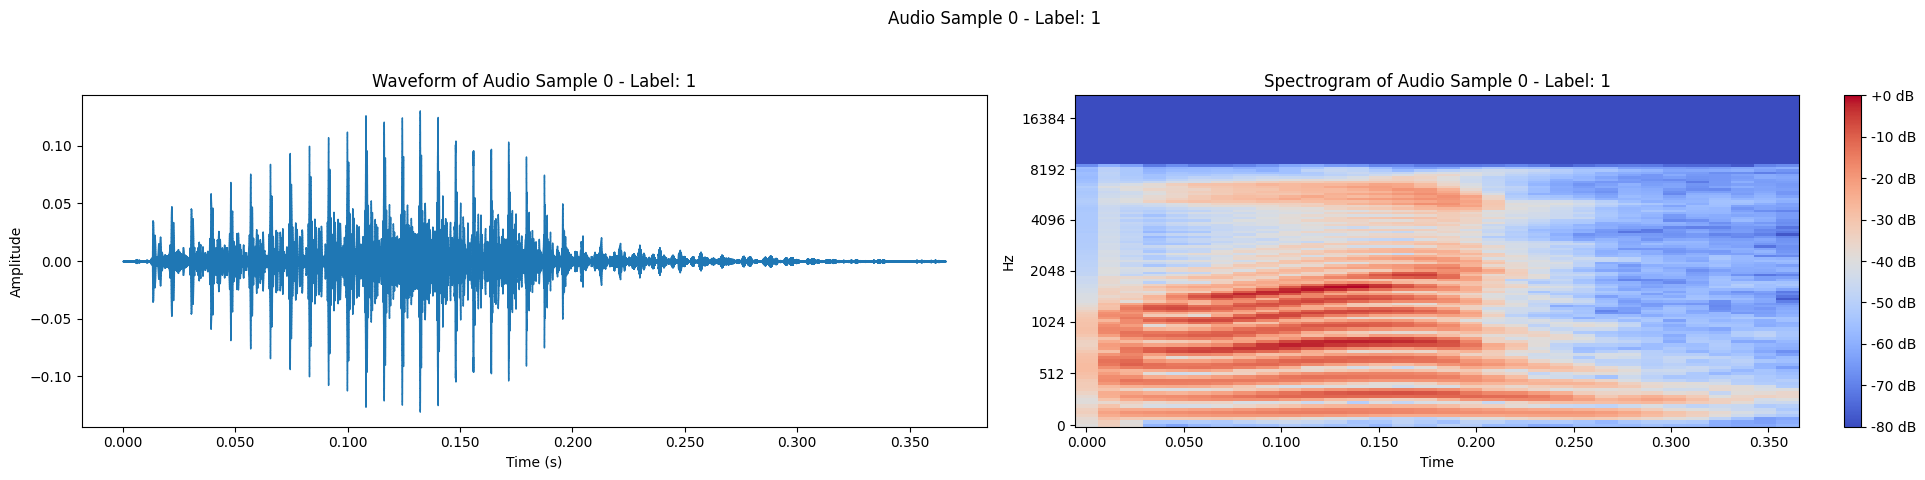

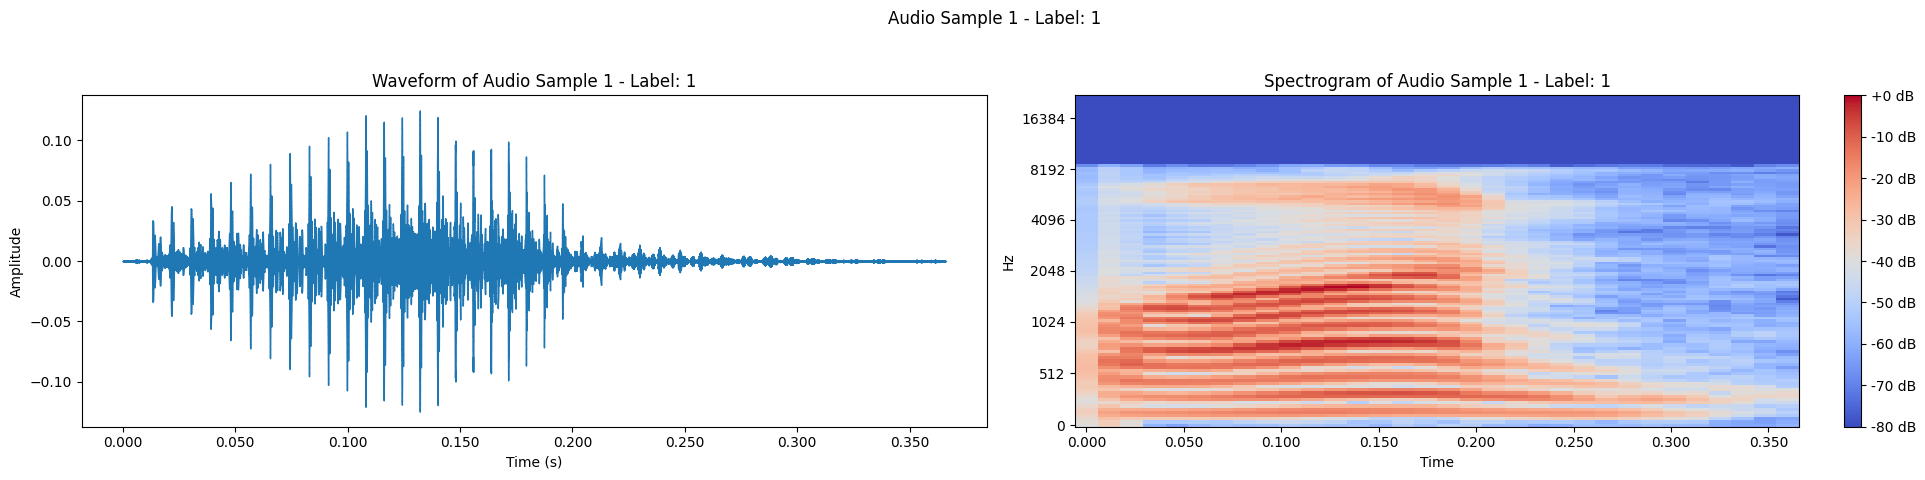

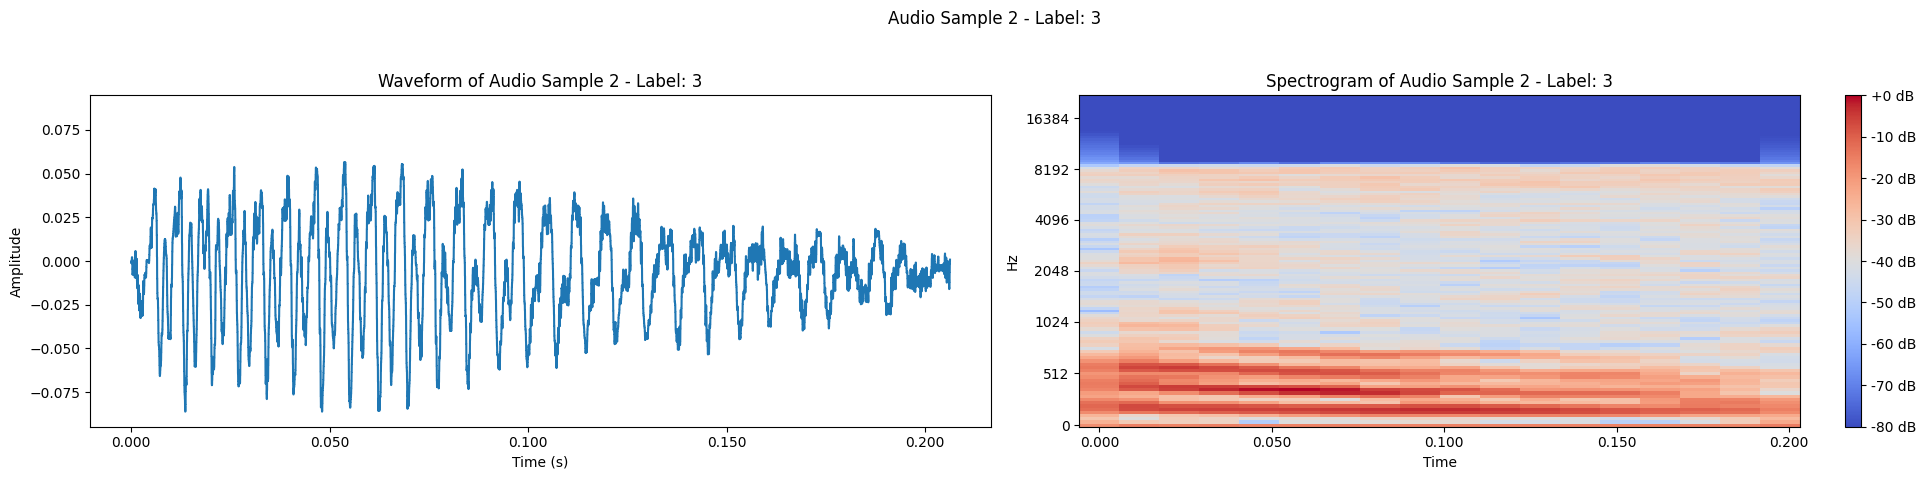

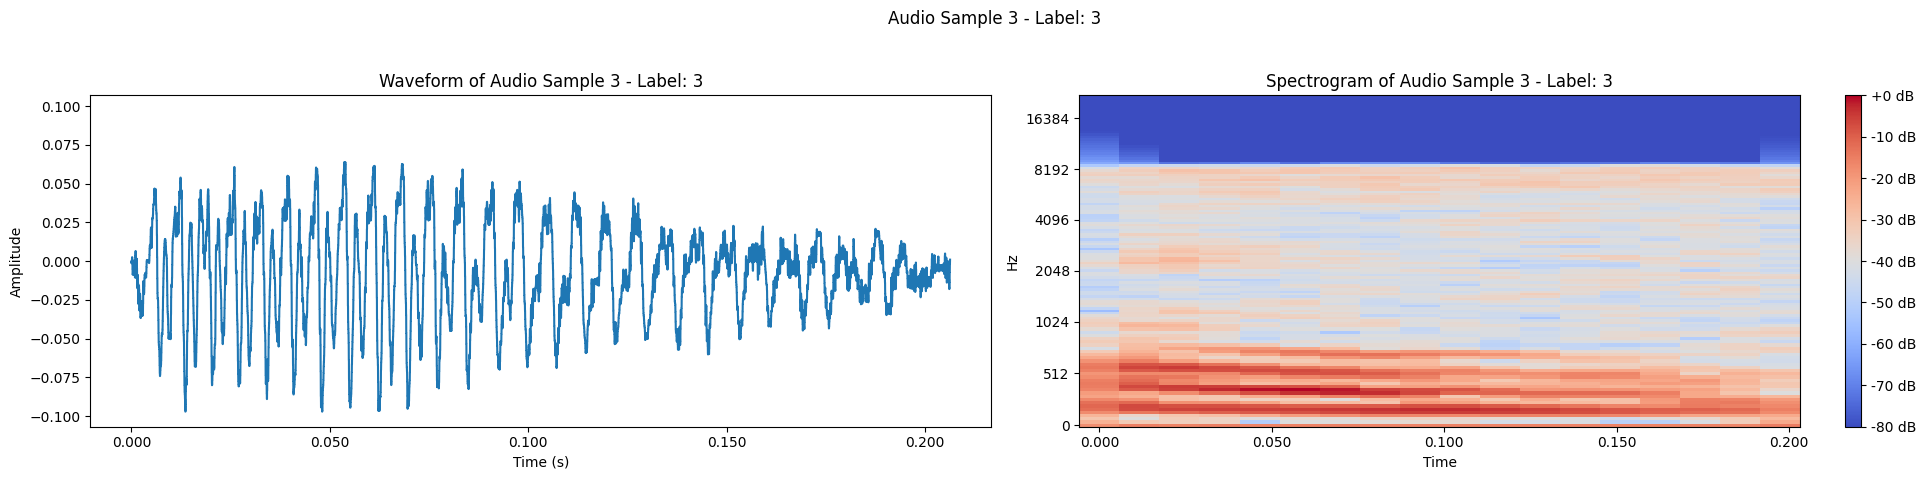

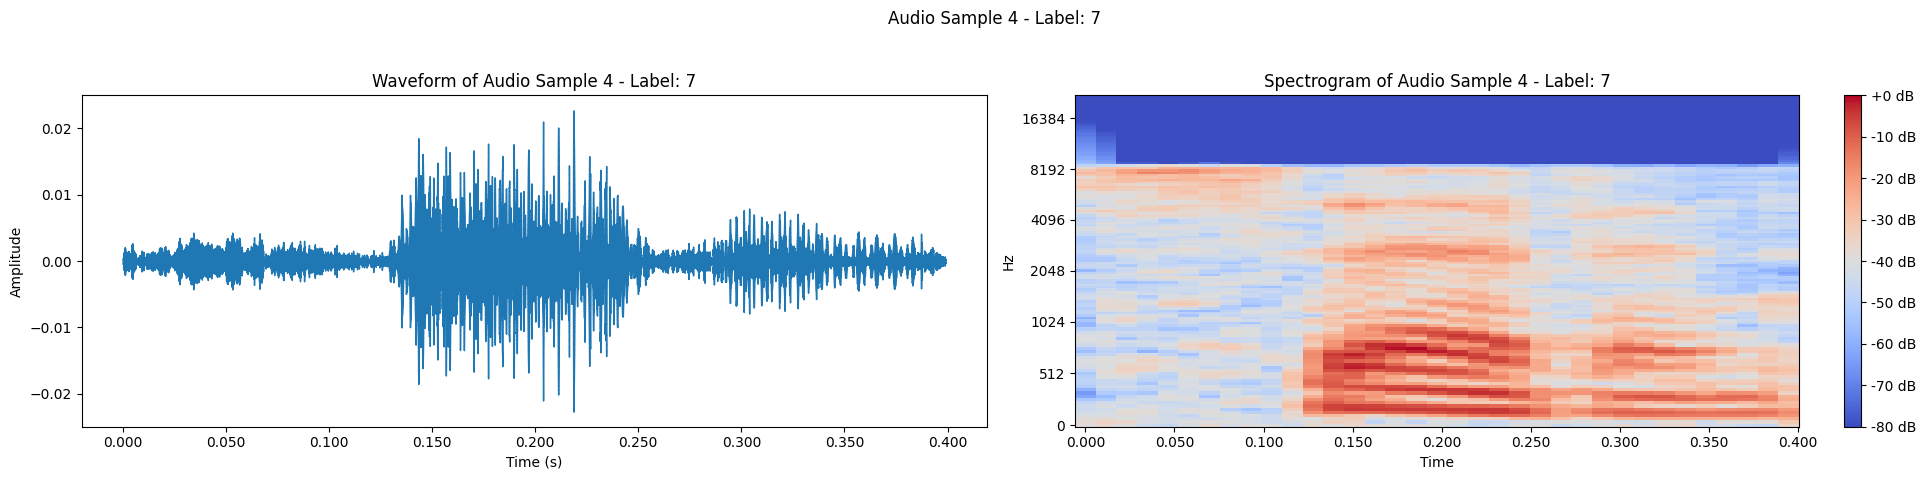

In [39]:
def augmentation_function_extra_1(x, pitch_scale_min=0.8, pitch_scale_max=1.2):
    import numpy as np
    x = x * np.random.uniform(pitch_scale_min, pitch_scale_max)  # Randomly scale the amplitude higher per sample
    return x
X_audio_augmented, y_audio_augmented, wavs_augmented = load_audio_data_noisy('data_util/AudioMNIST/free-spoken-digit-dataset-master/recordings', augmentation_function_extra_1, max_samples=max_samples)
X_audio_train_augmented, _, y_audio_train_augmented, _ = train_test_split(X_audio_augmented, y_audio_augmented, test_size=0.2, random_state=42)
visualize_waveform_and_play_audio(y_audio_augmented[:5], wavs_augmented[:5])

100%|██████████| 100/100 [00:04<00:00, 24.58it/s]


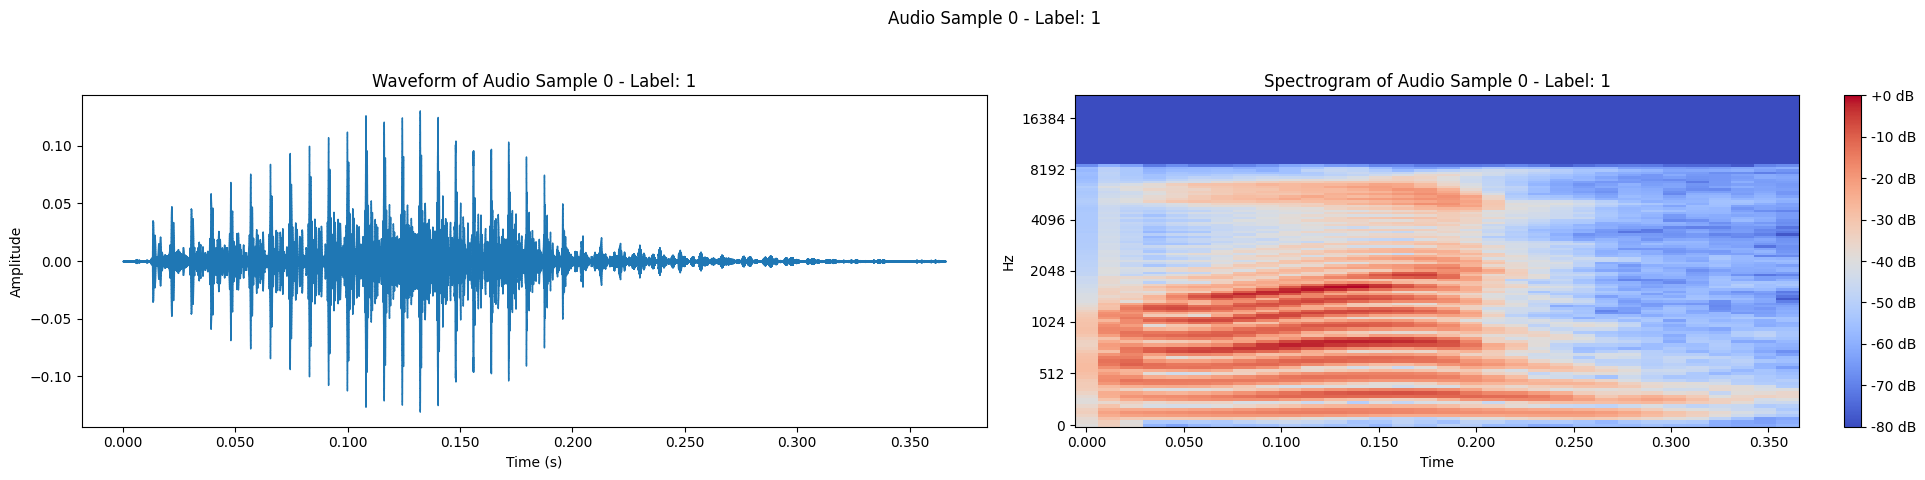

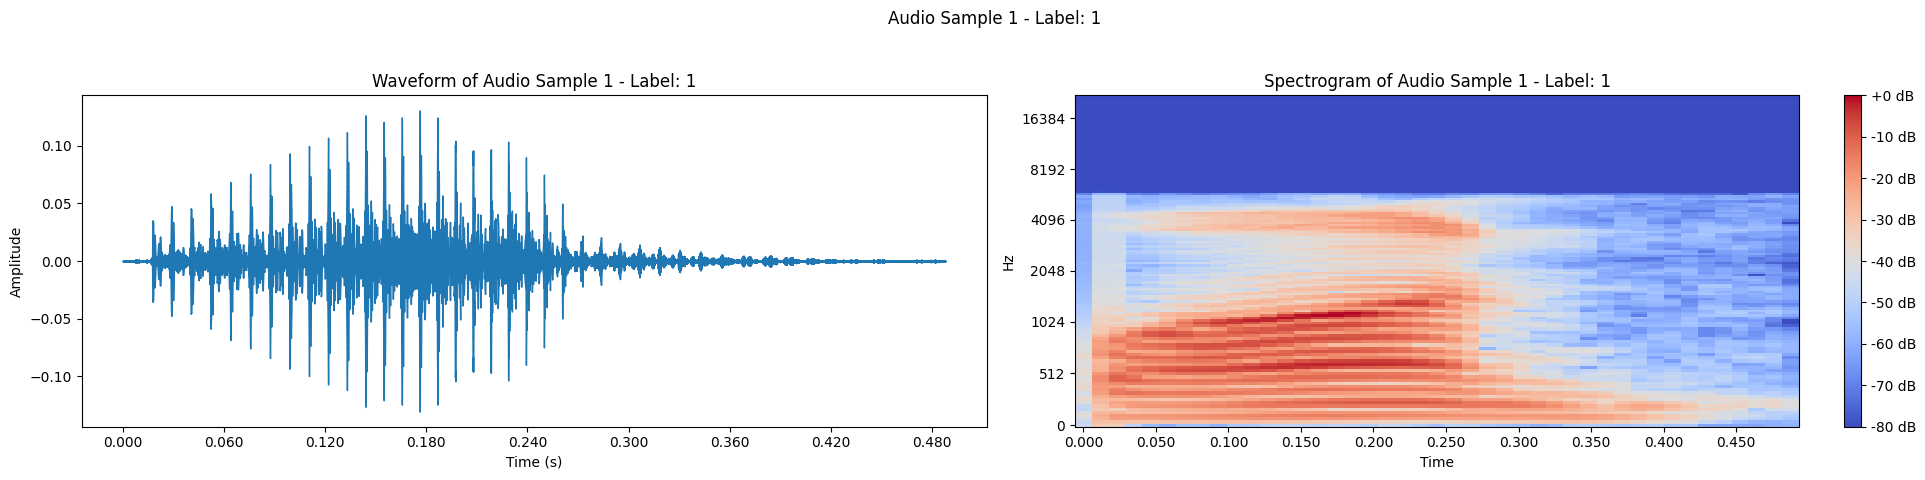

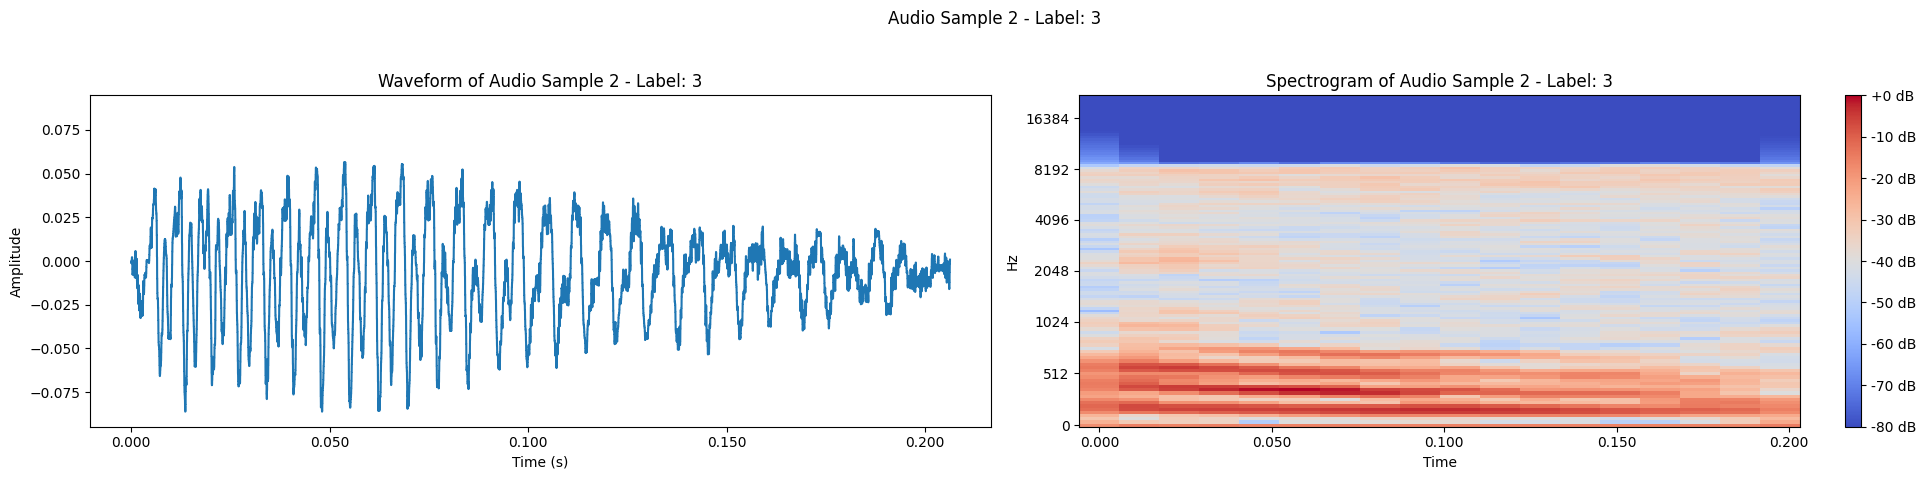

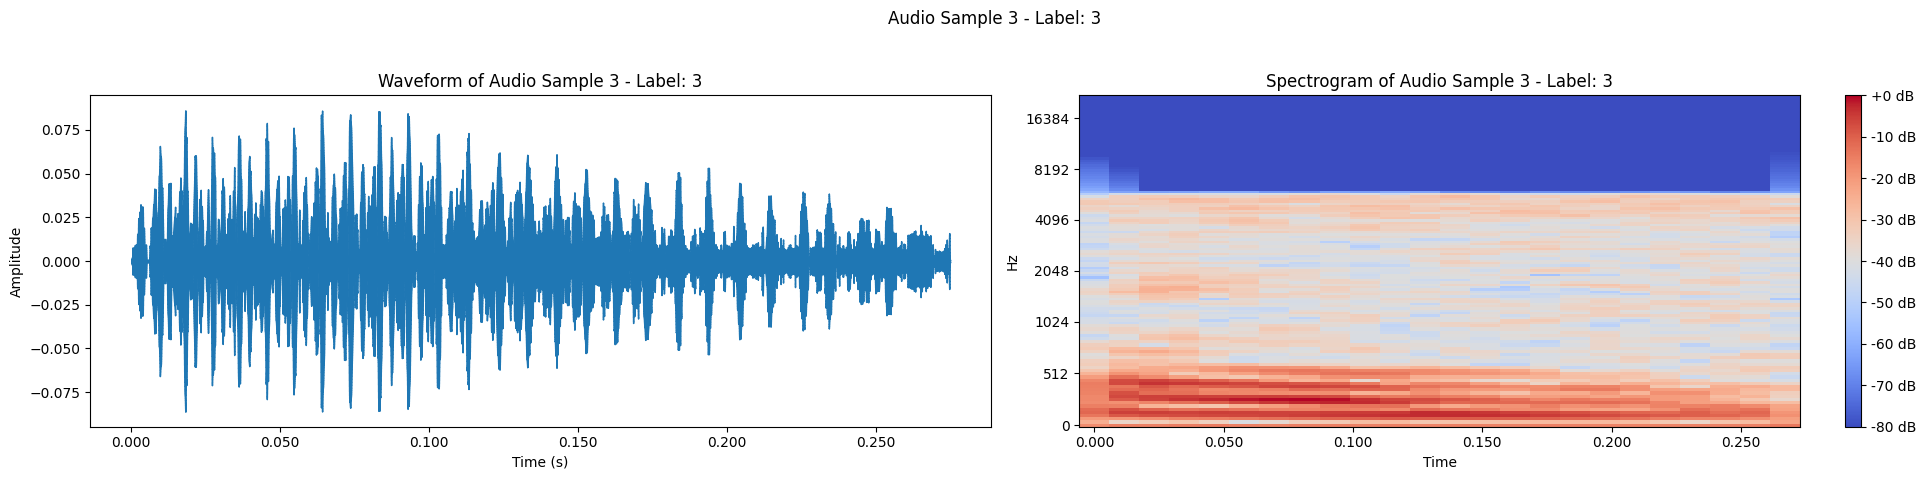

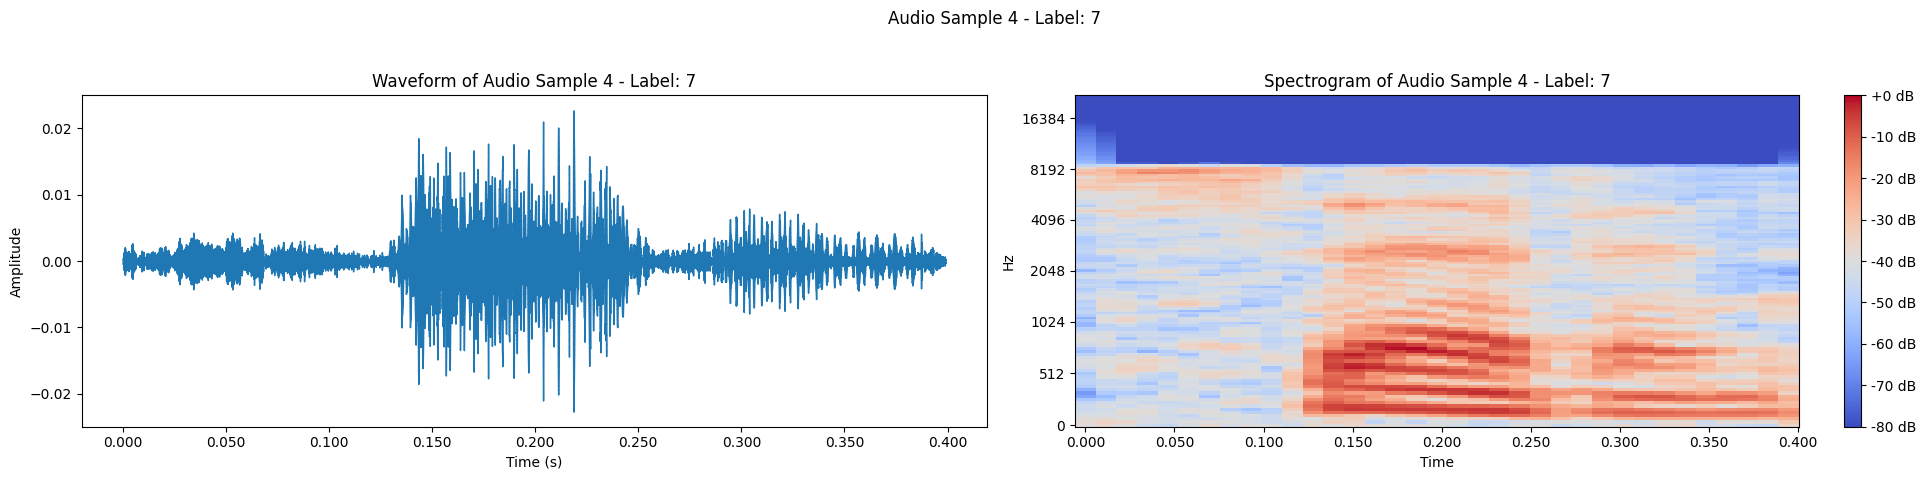

In [40]:
def augmentation_function_extra_2(x, slow_down_factor=0.75):
    import numpy as np
    x = np.interp(np.arange(0, len(x), slow_down_factor), np.arange(0, len(x)), x)
    return x
X_audio_augmented, y_audio_augmented, wavs_augmented = load_audio_data_noisy('data_util/AudioMNIST/free-spoken-digit-dataset-master/recordings', augmentation_function_extra_2, max_samples=max_samples)
X_audio_train_augmented, _, y_audio_train_augmented, _ = train_test_split(X_audio_augmented, y_audio_augmented, test_size=0.2, random_state=42)
visualize_waveform_and_play_audio(y_audio_augmented[:5], wavs_augmented[:5])

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
Explain what the additional two augmentations are in `augmentation_function_extra_1` and `augmentation_function_extra_2` are, and why they work.

---

**Answer:**  
The amplitude regulates how high the pitch is at the current time step, while creating more interpreted values either speeds or slows down the playback.

</div>


Below we have a final augmentation function using all three. Try to see how you can combine them all.

In [41]:
def final_augmentation_audio(x, pitch_scale_min=0.8, pitch_scale_max=1.2, slow_down_factor=0.75, sigma=0.01):
    import numpy as np
    x = x * np.random.uniform(pitch_scale_min, pitch_scale_max) 
    x = np.interp(np.arange(0, len(x), slow_down_factor), np.arange(0, len(x)), x)
    x = x + np.random.normal(0, sigma, len(x))  
    return x

X_audio_augmented, y_audio_augmented, wavs_augmented = load_audio_data_noisy('data_util/AudioMNIST/free-spoken-digit-dataset-master/recordings', final_augmentation_audio, max_samples=max_samples)
X_audio_train_augmented, _, y_audio_train_augmented, _ = train_test_split(X_audio_augmented, y_audio_augmented, test_size=0.2, random_state=42)

100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


#### Training the Models

In this section, we give an illustrative example, of how training such a model works with and without data augmentations, and try to illustrate the *possible* benefits of it. Gradient Boosting Trees are used, but you do not need to concern yourself with their implementation for today. 

In [42]:
subset_size = 1000
samples_per_class = subset_size // 10

balanced_indices = get_balanced_indices_by_targets(y_audio_train, samples_per_class, n_classes=10)
X_audio_train_subset = X_audio_train[balanced_indices]
y_audio_train_subset = y_audio_train[balanced_indices]
balanced_indices = get_balanced_indices_by_targets(y_audio_train_augmented, samples_per_class, n_classes=10)
X_audio_train_augmented_subset = X_audio_train_augmented[balanced_indices]
y_audio_train_augmented_subset = y_audio_train_augmented[balanced_indices]

model_no_data_aug = GradientBoostingClassifier()
model_no_data_aug.fit(X_audio_train_subset, y_audio_train_subset)
acc_no_data_aug = model_no_data_aug.score(X_audio_test, y_audio_test)
print(f"Accuracy without data augmentation: {acc_no_data_aug:.4f}")

model_data_aug = GradientBoostingClassifier()
model_data_aug.fit(X_audio_train_augmented_subset, y_audio_train_augmented_subset)
acc_data_aug = model_data_aug.score(X_audio_test, y_audio_test)
print(f"Accuracy with data augmentation: {acc_data_aug:.4f}")


Accuracy without data augmentation: 0.3500
Accuracy with data augmentation: 0.9000


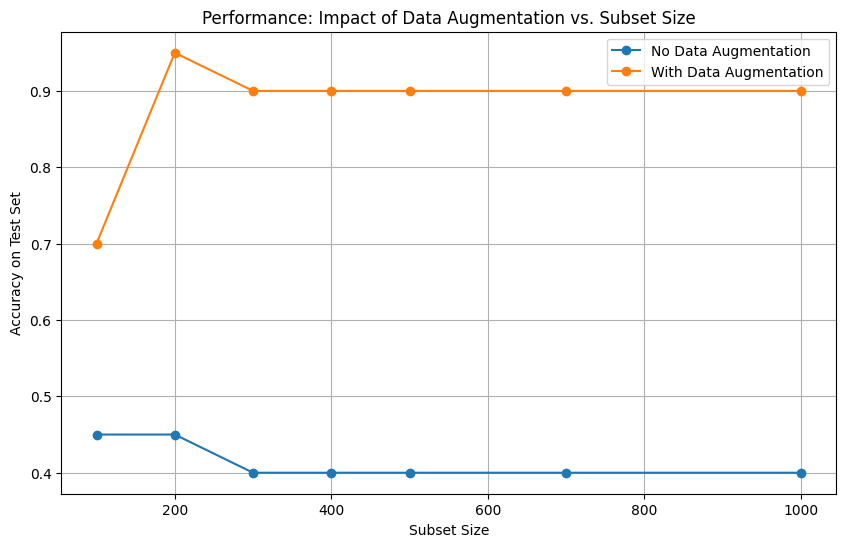

In [43]:
subset_sizes = [100, 200, 300, 400, 500, 700, 1000]  # Different subset sizes to try
acc_no_aug_list = []
acc_aug_list = []

for subset_size in subset_sizes:
    samples_per_class = subset_size // 10
    
    balanced_indices = get_balanced_indices_by_targets(y_audio_train, samples_per_class, n_classes=10)
    X_train_sub = X_audio_train[balanced_indices]
    y_train_sub = y_audio_train[balanced_indices]
    
    balanced_indices_aug = get_balanced_indices_by_targets(y_audio_train_augmented, samples_per_class, n_classes=10)
    X_train_aug_sub = X_audio_train_augmented[balanced_indices_aug]
    y_train_aug_sub = y_audio_train_augmented[balanced_indices_aug]
    
    model_no_aug = GradientBoostingClassifier()
    model_no_aug.fit(X_train_sub, y_train_sub)
    acc_no_aug = model_no_aug.score(X_audio_test, y_audio_test)
    acc_no_aug_list.append(acc_no_aug)

    model_aug = GradientBoostingClassifier()
    model_aug.fit(X_train_aug_sub, y_train_aug_sub)
    acc_aug = model_aug.score(X_audio_test, y_audio_test)
    acc_aug_list.append(acc_aug)

plot_accuracy_vs_subset_size(
    subset_sizes=subset_sizes,
    acc_no_aug=acc_no_aug_list,
    acc_with_aug=acc_aug_list,
    title='Performance: Impact of Data Augmentation vs. Subset Size'
)

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
In the plot showing the performance of the models across different subset sizes (imitating different dataset sizes in general), please reason about why the two accuracies end up different from each other, even if we use data augmentation? Why is data augmentation lower in the beginning?

---

**Answer:**  
It's only natural, the dataset size getting increased means we get a larger variety of samples, which ends up compensating for the missing data above.  Data augmentation may be too much at times, and instead confuse the model when the data size is too small. At what point are we learning the noise and not the actual data. It is careful dance between augmenting too much and too little. However, we can see that after a certain threshold, it does end up making our model more robust on the same test set.

</div>


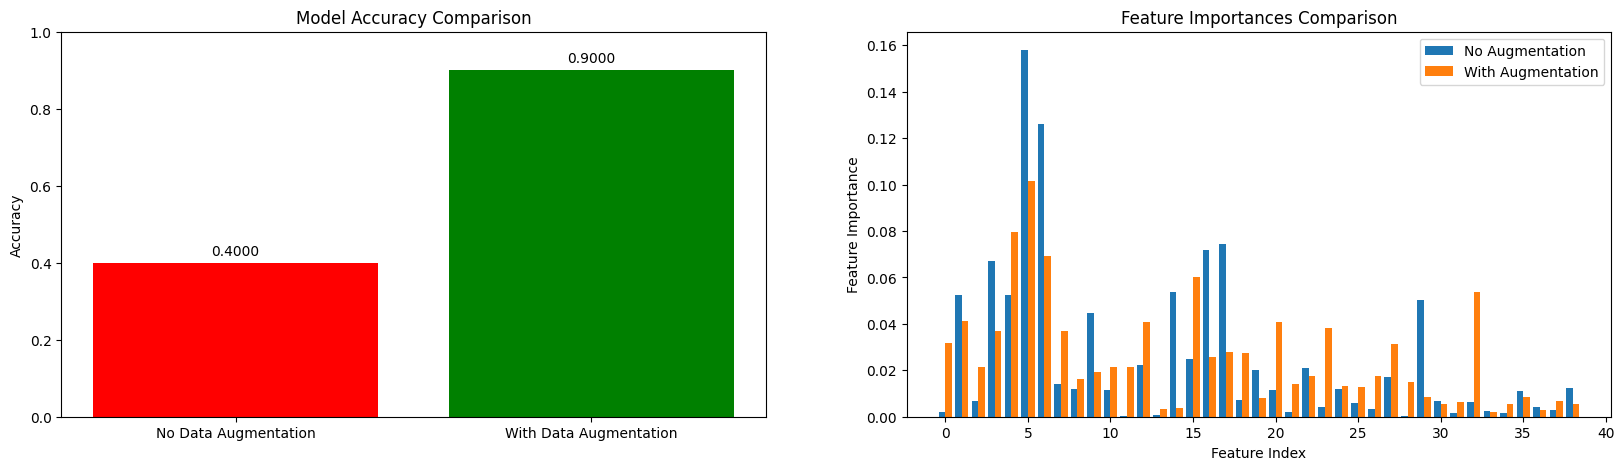

In [44]:
plot_aug_comparison(acc_no_aug_list, acc_aug_list, model_no_data_aug, model_data_aug)

### Images

In [45]:
def train(model, train_dataloader, val_dataloader, epochs=3):
    model.train()
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    for epoch in tqdm(range(epochs)):
        train_loss = []
        for images, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_losses.append(np.mean(train_loss))
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_dataloader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))
    return train_losses, val_losses

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
menu = retrieve_mnist_menu()
menu

## Theoretical Questions

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
In the plot showing the performance of the models across different subset sizes (imitating different dataset sizes in general), please reason about why the two accuracies end up different from each other, even if we use data augmentation? Why is data augmentation lower in the beginning?

---

**Answer:**  
It's only natural, the dataset size getting increased means we get a larger variety of samples, which ends up compensating for the missing data above.  Data augmentation may be too much at times, and instead confuse the model when the data size is too small. At what point are we learning the noise and not the actual data. It is careful dance between augmenting too much and too little. However, we can see that after a certain threshold, it does end up making our model more robust on the same test set.

</div>


## Exercise: Creating Your Own Data Augmentation Pipeline

The time has come. After seeing our examples and playing around with how the given numbers look around, we want you to arrange your own set of augmentations. Your task is to find an augmentation to boost the performance on a training and validation set on a subset of data we offer you. 

You will do all of this in the `transform_aug` variables, which takes in a list of augmentations. This list is currently empty (except for the normalization step, which we leave as an exercise for the reader to know why it is there). Throughout this notebook we have been using the *Albumentations* library to do our data augmentations. This will continue to be the case here. You are free to select from any of the following functions there, and adjust their parameters. Namely:
- `A.Rotate(float rotate, float p)`  
- `A.Affine(float translate_x, float translate_y, float scale, float p)`  
- `A.GaussianBlur(int gaussian_kernel_size, float blur_sigma, float p, bool gaussian_blur)`  
- `A.HorizontalFlip(float p, bool horizontal_flip)`  
- `A.VerticalFlip(float p, bool vertical_flip)`  
- `A.RandomBrightnessContrast(float p, bool random_brightness_contrast)`  
- `A.RGBShift(float p, bool rgb_shift)`  

**Important**: Please take note that sometimes the function can take in both a number, a tuple, and a list!! 

The API of the augmentations is provided on this link https://albumentations.ai/docs/api-reference/. Be careful - the optimal combination may not be all of those augmentations at once, or with all of the parameters! 


In [47]:
transform_aug = AlbumentationsTransform(A.Compose([
            # Add your chosen augmentations here, e.g.:
            # A.Rotate(limit=(float rotate), float p), p=0.
            A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
]))

p=0.5
transform_aug = AlbumentationsTransform(A.Compose([
            A.Rotate(limit=(-1.0*15, 15), p=0.5),
            A.Affine(translate_percent={'x': 0.1, 'y': 0.1}, p=p),
            A.GaussianBlur(blur_limit=3, sigma_limit=2, p=p),
            A.RandomBrightnessContrast(p=p),
            A.Perspective(scale=(0.05, 0.1), p=p),
            A.RGBShift(p=p),
            A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
        ]))

<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
How often would you choose to apply the data augmentation with the parameter **p**? Justify.

---

**Answer:**  
Except **p=0**, and arguably **p=1** there is no wrong answer. The more often you apply the data augmentation, the more you also lose the representation of your original data. In theory, that might be fine if the data augmentations are minor enough, but if excessive you would likely receive worse performance. If **p=0**, there's just no data augmentation, removing the point completely.

</div>


<div style="
  font-family: Arial, sans-serif;
  background: #00e5ff;
  color: #0b1220;
  padding: 15px 20px;
  border-radius: 12px;
  line-height: 1.6;
  max-width: 650px;
">

**Question:**  
What data augmentations did you choose and why? Are there any data augmentations you did NOT choose? If so, why? Feel free to come back to this questions after experiemnting.

---

**Answer:**  
We expect the students to use a combination of blurs, (moderate) rotations and affine transofmrations or anything to change the color distribution of the image. Performance should decrease in case of data augmentations that "flip" the label in some way (zooming in too much to an 8, roating a 6). Things like that confuse the models instead of making them more robust against noise.

</div>


In [48]:
transform_no_aug = AlbumentationsTransform(A.Compose([
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
]))

## Dataset Parameters and Visualization

Here we set you the subset size you will be working on with your data augmentation from the code cell above. The expectation is that accuracy will increase for the correct set of data augmentation. Play around it - adjust the size of the dataset if you wish to or the samples per class, which attemt to balance out your distribution.

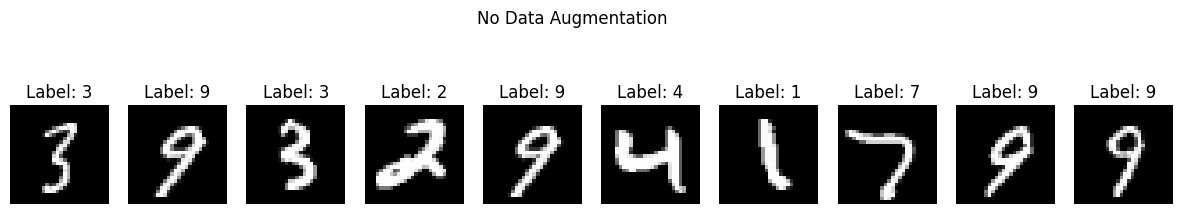

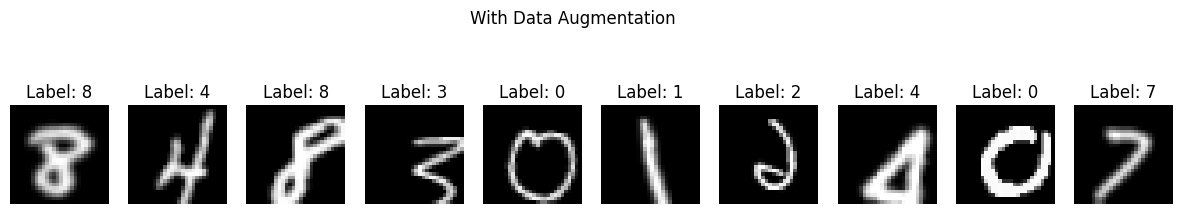

In [49]:
subset_size = 1000
num_classes = 10
epochs = 100 #WARNING - IF TOO LOW, MAY NOT WORK
samples_per_class = subset_size // 10

trainset_no_aug, valset_no_aug, _, trainloader_no_aug, valloader_no_aug, testloader = load_mnist_data(train=True,data_augmentations=transform_no_aug,  subset_size=subset_size, )
trainset_aug, valset_aug, _,  trainloader_aug, valloader_aug, _ = load_mnist_data(train=True, data_augmentations=transform_aug, subset_size=subset_size)

visualize_pytorch_dataset_images(trainset_no_aug, "No Data Augmentation")
visualize_pytorch_dataset_images(trainset_aug, "With Data Augmentation")

In [50]:
model_no_aug = SimpleCNN()
losses_no_aug_train, losses_no_aug_val = train(model_no_aug, trainloader_no_aug, valloader_no_aug, epochs=epochs)
acc_no_aug = test(model_no_aug, testloader)

model_aug = SimpleCNN()
losses_aug_train, losses_aug_val = train(model_aug, trainloader_aug, valloader_no_aug, epochs=epochs)
acc_aug = test(model_aug, testloader)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Accuracy without augmentation: 0.9294
Accuracy with augmentation: 0.9440


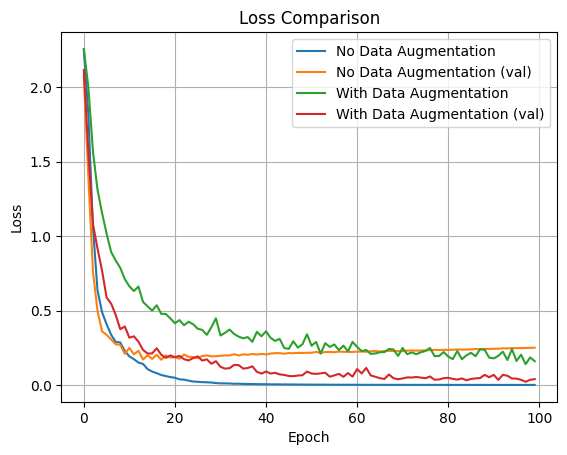

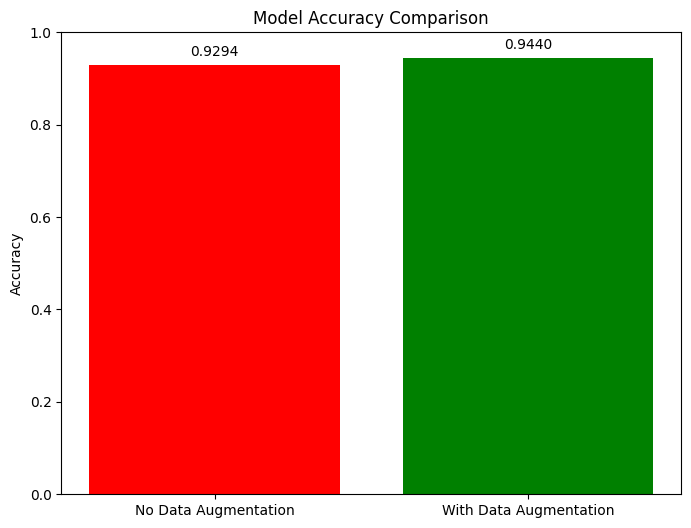

In [51]:
from visualization.show_metrics import compare_two_losses
import matplotlib.pyplot as plt

print(f"Accuracy without augmentation: {acc_no_aug:.4f}")
print(f"Accuracy with augmentation: {acc_aug:.4f}")

def compare_two_losses(loss_a, loss_a_val, loss_a_label, loss_b, loss_b_val, loss_b_label):


    plt.plot(loss_a, label=loss_a_label)
    plt.plot(loss_a_val, label=loss_a_label + ' (val)')
    plt.plot(loss_b, label=loss_b_label)
    plt.plot(loss_b_val, label=loss_b_label + ' (val)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.title('Loss Comparison')
    plt.show()
    

def plot_accuracy_comparison(acc_no_aug_list, acc_aug_list):
    accuracies = [acc_no_aug_list[-1], acc_aug_list[-1]]
    labels = ['No Data Augmentation', 'With Data Augmentation']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, accuracies, color=['red', 'green'])
    plt.ylim([0, 1])
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center')

    plt.show()

    
compare_two_losses(losses_no_aug_train, losses_no_aug_val, 'No Data Augmentation', losses_aug_train, losses_aug_val, "With Data Augmentation")
plot_accuracy_comparison([acc_no_aug], [acc_aug])

100%|██████████| 10/10 [01:38<00:00,  9.84s/it]


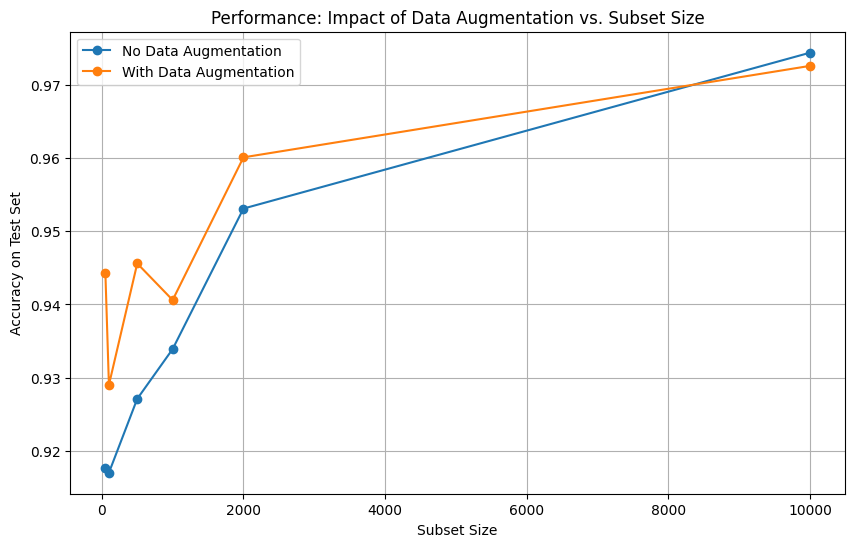

In [52]:
subset_sizes = [50, 100, 500, 1000, 2000, 10000]  # Different subset sizes to try
num_classes = 10
epochs = 100 #WARNING - IF TOO LOW, MAY NOT WORK
samples_per_class = subset_size // 10

acc_no_aug_list = []
acc_aug_list = []

for subset_size in subset_sizes:
    num_classes = 10
    samples_per_class = subset_size // 10
    
    num_classes = 10
    epochs = 10 #WARNING - IF TOO LOW, MAY NOT WORK
    samples_per_class = subset_size // 10

    trainset_no_aug, valset_no_aug, _, trainloader_no_aug, valloader_no_aug, testloader = load_mnist_data(train=True,data_augmentations=transform_no_aug,  subset_size=subset_size, )
    trainset_aug, valset_aug, _,  trainloader_aug, valloader_aug, _ = load_mnist_data(train=True, data_augmentations=transform_aug, subset_size=subset_size)
    
    model_no_aug_curr = SimpleCNN()
    losses_no_aug_train, losses_no_aug_val = train(model_no_aug, trainloader_no_aug, valloader_no_aug, epochs=epochs)
    acc_no_aug_curr = test(model_no_aug, testloader)

    model_aug_curr = SimpleCNN()
    losses_aug_train, losses_aug_val = train(model_aug, trainloader_aug, valloader_no_aug, epochs=epochs)
    acc_aug_curr = test(model_aug, testloader)

    acc_no_aug_list.append(acc_no_aug_curr)
    acc_aug_list.append(acc_aug_curr)

plot_accuracy_vs_subset_size(
    subset_sizes=subset_sizes,
    acc_no_aug=acc_no_aug_list,
    acc_with_aug=acc_aug_list,
    title='Performance: Impact of Data Augmentation vs. Subset Size'
)

### Contrail Application

Now comes the time to apply our data augmentations to real data, not just a toy problem like MNIST. 

We are in luck, however! We can (mostly) just reapply all of the data augmentations we have done to MNIST. The following section details how data augmentation is applied and lets you play with another set of augmentations to improve contrail performance. 

Alternatively, you could also take a look at our set of data augmentatiosn they are not necessarily the best set of augmentations for all cases. Please answer all of the theoretical questions, and run through the code. Our configuration of data augmentations is not necessarily optimal.

In [3]:
from visualization.interactive_menu import retrieve_contrails_menu
menu = retrieve_contrails_menu()
menu

In [2]:
# transform_aug = A.Compose([
#     A.Rotate(limit=15, p=0.5),
#     A.Affine(translate_percent=(0.1, 0.1), p=0.5),
#     A.Resize(128, 128),
#     A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
# ])


transform_no_aug_contrails = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
])

train_contrail_network(transform_no_aug_contrails, 50, "dice", "base", dataset="google")


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
p=0.5
import cv2
transform_contrails_aug = AlbumentationsTransform(A.Compose([
            A.Resize(128, 128),
            A.Rotate(limit=(-1.0*15, 15), border_mode=cv2.BORDER_REFLECT_101, p=0.5),
            A.Affine(translate_percent={'x': 0.1, 'y': 0.1}, border_mode=cv2.BORDER_REFLECT_101, p=p),
            A.GaussianBlur(blur_limit=3, sigma_limit=2, p=p),
            A.RandomBrightnessContrast(p=p),
            A.Perspective(scale=(0.05, 0.1), border_mode=cv2.BORDER_REFLECT_101, p=p),
            A.RGBShift(p=p),
            A.Normalize(mean=0.5, std=0.5, max_pixel_value=255.0),
        ]))

train_contrail_network(transform_contrails_aug, 50, "dice", "base")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (327356685.py, line 4)